# **New York City Taxi Trip Data**

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

fig_path = '/content/drive/MyDrive/DataMining/Figures/'
data_path = '/content/drive/MyDrive/DataMining/Dataset/'
transformed_data = '/content/drive/MyDrive/DataMining/Dataset/Taxi_Trip_Transformed_Data.csv'

Mounted at /content/drive


In [5]:
data = pd.read_csv(data_path + "Taxi_Trip_Cleaned_Data.csv")
zone = pd.read_csv(data_path + "taxi_zone_geo.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8319926 entries, 0 to 8319925
Data columns (total 21 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Unnamed: 0               int64  
 1   trip_distance            float64
 2   rate_code                int64  
 3   store_and_fwd_flag       object 
 4   payment_type             int64  
 5   fare_amount              float64
 6   extra                    float64
 7   mta_tax                  float64
 8   tip_amount               float64
 9   tolls_amount             float64
 10  imp_surcharge            float64
 11  total_amount             float64
 12  pickup_location_id       int64  
 13  dropoff_location_id      int64  
 14  year                     int64  
 15  month                    int64  
 16  day                      int64  
 17  day_of_week              int64  
 18  hour_of_day              int64  
 19  trip_duration            float64
 20  calculated_total_amount  float64
dtypes: float

In [6]:
# supprimer le premier colone
data = data.iloc[:, 1:]
# Afficher les premier lignes
data.head()

,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration,calculated_total_amount
0,16.97,1,N,1,49.5,0.0,0.5,5.61,5.76,0.3,61.67,231,138,2018,3,29,3,13,3317.0,61.67
1,14.45,1,N,1,45.5,0.0,0.5,10.41,5.76,0.3,62.47,87,138,2018,3,29,3,14,3648.0,62.47
2,11.60,1,N,1,42.0,0.0,0.5,14.57,5.76,0.3,63.13,68,138,2018,3,29,3,14,3540.0,63.13
3,5.10,1,N,1,26.5,1.0,0.5,5.65,0.00,0.3,33.95,186,33,2018,3,29,3,16,2585.0,33.95
4,11.11,1,N,1,45.5,1.0,0.5,10.61,5.76,0.3,63.67,163,138,2018,3,29,3,16,4521.0,63.67


Visualisation des données

# Visualisation, transformation et analyse des données
Les étapes suivantes de transformation des données sont appliquées aux données nettoyées, afin de faciliter l'analyse et l'exploration ultérieures des données.



## Construction d'attributs composites/dérivés
La construction d'attributs composites et dérivés peut grandement faciliter la phase d'apprentissage et d'analyse de l'exploration des données. Les relations simplexes entre les attributs de données qui peuvent ne pas être prises en compte par les modèles d'analyse en aval peuvent être exprimées par des attributs explicitement calculés en combinant un ou plusieurs attributs préexistants.

Calcul et ajout de la vitesse de conduite
Un attribut driving_speed en plus des attributs de données existants peut être utile pour analyser les données de trafic dans différentes zones géographiques de la ville. La vitesse moyenne peut être directement corrélée à la densité du trafic.

In [7]:
trip_distance_array = data['trip_distance']
trip_duration_array = data['trip_duration']

# driving_speed = trip_dist (in miles) / trip_duration (in sec) * 3600 sec
driving_speed = np.divide(trip_distance_array, trip_duration_array)*3600

data['driving_speed'] = pd.Series(driving_speed)

# Calculer et ajouter le taux de pourboire
Le taux de pourboire peut aider à analyser la proportion générale de pourboire que les chauffeurs de taxi paient habituellement pour leur course.

In [8]:
tip_amount_array = data['tip_amount']
total_amount_array = data['total_amount']

# tipping rate = tip_amount / total_amount
tipping_rate = np.divide(tip_amount_array, total_amount_array)

data['tipping_rate'] = tipping_rate

Tracé de la vitesse moyenne des taxis par heure. Elles sont particulièrement prononcées dans les codes de tarification 2 à 4, qui correspondent à des zones situées en dehors du centre-ville, comme l'aéroport JFK ou le comté de Nassau.

Ces baisses seraient plus marquées si nous n'utilisions que les données relatives aux jours ouvrables, mais nous y reviendrons plus tard.

<Axes: xlabel='hour_of_day', ylabel='avg_speed'>

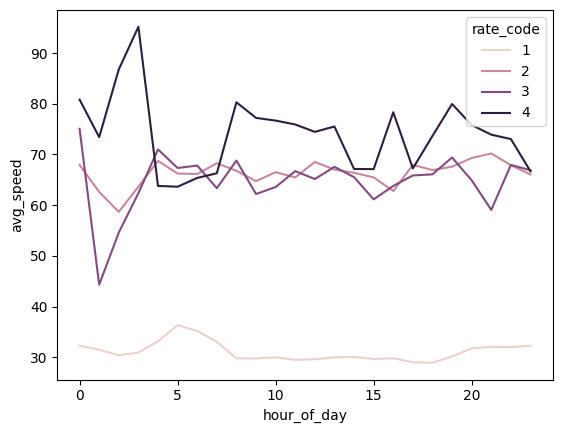

In [9]:
avg_speed_by_h = data[(data['trip_duration']>36)&(data['rate_code']<5)].groupby(by=['hour_of_day','rate_code'],as_index=False).agg(avg_speed=('driving_speed','mean'))
sns.lineplot(data=avg_speed_by_h,x='hour_of_day',y='avg_speed',hue='rate_code')

Nous allons maintenant voir les différences dans la demande de taxis à différents moments de la journée et comment elle évolue entre les jours ouvrables et les week-ends.

Il est important de se rappeler qu'il ne faut pas comparer les valeurs absolues car notre diagramme à barres montre le nombre de courses et la semaine ne compte que deux week-ends contre cinq jours ouvrables.

Que peut-on donc voir sur ce graphique ?

Nous pouvons constater la différence entre les demandes les plus faibles des jours ouvrables et des week-ends : les jours ouvrables, le plus grand nombre de personnes dormant (probablement) se situe aux alentours de 2-3 heures du matin, tandis que les week-ends, il se situe à 17 heures.

Les week-ends ont également leurs propres pics de demande de taxis : de la fin de l'après-midi au soir, lorsque les gens sortent, et vers minuit lorsqu'ils rentrent chez eux.

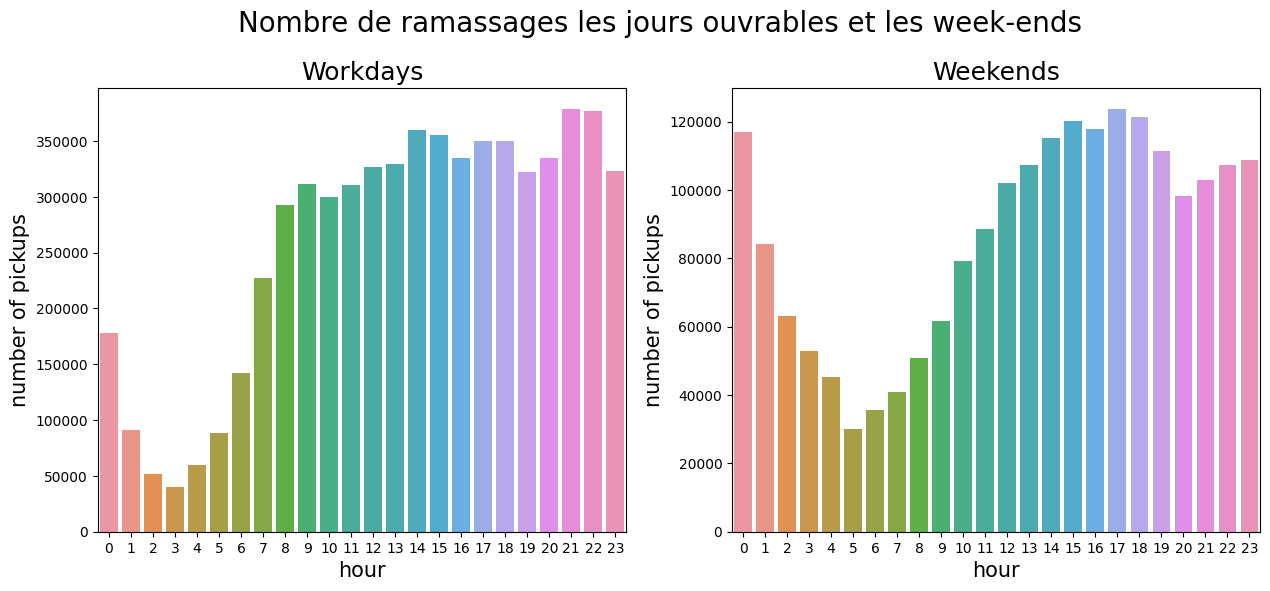

In [10]:
fig, axes = plt.subplots(figsize=(15,6), nrows=1, ncols=2)
workday_data = data.loc[data['day_of_week']<5]
weekend_data = data.loc[data['day_of_week']>=5]

sns.countplot(ax=axes[0], x=workday_data['hour_of_day'])
sns.countplot(ax=axes[1], x=weekend_data['hour_of_day'])

axes[0].set_title('Workdays',fontsize = 18)
axes[0].set_xlabel('hour', fontsize=15)
axes[0].set_ylabel('number of pickups', fontsize=15)
axes[1].set_title('Weekends',fontsize = 18)
axes[1].set_xlabel('hour', fontsize=15)
axes[1].set_ylabel('number of pickups', fontsize=15)

fig.suptitle('Nombre de ramassages les jours ouvrables et les week-ends',fontsize = 20)
plt.subplots_adjust(top = 0.85)
plt.show;

#Carte choroplèthe animée !
L'auteur a pris beaucoup de plaisir à réaliser cette partie et est très fier du résultat.

Brève explication de ce qui se passe ici :

* Quelques importations supplémentaires
* Suppression des trajets depuis les aéroports (pour des raisons de lisibilité de la carte)
* Création d'une image pour chaque heure de la journée
* Combinaison de ces images dans un gif

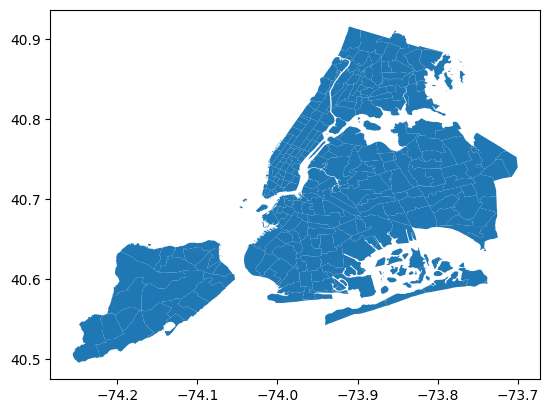

In [11]:
import geopandas as gpd
import imageio
from shapely import wkt

zone['zone_geom'] = zone['zone_geom'].apply(wkt.loads)

airports_mask = zone['zone_name'].str.contains('Airport|airport|AIRPORT',regex=True,na=False)
zone_no_airports = zone[~airports_mask]
zone_no_airports_geo = gpd.GeoDataFrame(data=zone_no_airports, geometry='zone_geom')
zone_no_airports_geo.plot();

In [12]:
def image_of_hour(hour_trips, hour):
    fig,axs = plt.subplots(figsize=(20,10),nrows=1,ncols=2)

    pickups_by_zone = hour_trips.groupby('pickup_location_id', as_index=False).agg(num_pickups=('pickup_location_id','count'))
    pickups_geom = pickups_by_zone.merge(zone_no_airports_geo, how='right', left_on='pickup_location_id', right_on='zone_id')
    pickups_geom['num_pickups'].fillna(0,inplace=True)
    pickups_geo = gpd.GeoDataFrame(data=pickups_geom, geometry='zone_geom')
    pickups_geo.plot(ax=axs[0],column='num_pickups',cmap='Blues')
    axs[0].axis('off')

    dropoffs_by_zone = hour_trips.groupby('dropoff_location_id', as_index=False).agg(num_dropoffs=('dropoff_location_id','count'))
    dropoffs_geom = dropoffs_by_zone.merge(zone_no_airports_geo, how='right', left_on='dropoff_location_id', right_on='zone_id')
    dropoffs_geom['num_dropoffs'].fillna(0,inplace=True)
    dropoffs_geo = gpd.GeoDataFrame(data=dropoffs_geom, geometry='zone_geom')
    dropoffs_geo.plot(ax=axs[1],column='num_dropoffs',cmap='OrRd')
    axs[1].axis('off')

    plt.subplots_adjust(left=0,right=1,bottom=0,wspace=0,top=1)
    fig.suptitle(f'Nombre de prises en charge (à gauche) et de déposes (à droite) entre {hour}:00 and {hour}:59', fontsize=30)
    plt.savefig(f'/content/drive/MyDrive/DataMining/Figures/taxi_{hour}.png',transparent=False)
    plt.close

In [13]:
for hour in range(24):
    trips_slice = workday_data[workday_data['hour_of_day']==hour]
    image_of_hour(trips_slice,hour)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
frames = []
for hour in range(24):
    frame = imageio.v2.imread(f'/content/drive/MyDrive/DataMining/Figures/taxi_{hour}.png')
    frames.append(frame)

imageio.mimsave(fig_path + '/taxi_by_hour.gif',frames,fps=1)


In [15]:
from IPython.display import HTML
HTML('<img src="https://drive.google.com/file/d/10X2EG5j-1Ww7b2R-_kvAN9D2NGDJWMOI/view?usp=drive_link" />')

La première chose qui saute aux yeux, c'est que si les déposes se font dans toute la ville, la quasi-totalité des ramassages se font à Manhattan. L'explication a pris du temps, mais elle a fini par être trouvée. Outre les emblématiques taxis jaunes, il existe également des taxis verts (dont les enregistrements ne sont pas inclus dans cet ensemble de données), et ils ne peuvent pas prendre de passagers à Manhattan. Les chauffeurs de taxis jaunes utilisent donc leur avantage en effectuant parfois des prises en charge en dehors de Manhattan. Ils effectuent des prises en charge "à l'extérieur" plus activement aux heures de pointe du matin, comme le montre la carte.

Nous pouvons également voir clairement que les gens se déplacent vers le centre de Manhattan le matin et vers les quartiers environnants le soir, ce qui est cohérent avec les informations sur les différents quartiers de New York recueillies dans les films et les séries télévisées.)

# Transformation des données

# Normalisation des données
La normalisation des données est une pratique typique de la technique d'exploration des données qui consiste à transformer les colonnes numériques en une échelle standard. Étant donné que certaines valeurs de caractéristiques diffèrent des autres à plusieurs reprises, les caractéristiques ayant des valeurs plus élevées domineront le processus d'apprentissage et d'analyse. Il est donc utile de les ramener à la même échelle pour une analyse plus rapide et plus pertinente.

Une procédure simple de mise à l'échelle min-max est adoptée dans les cellules suivantes pour normaliser des attributs spécifiques. Étant donné que les informations statistiques sur la moyenne, la variance, etc. ne sont pas connues, il n'est pas possible d'appliquer des procédures de mise à l'échelle plus complexes et mieux informées.

##Tous les attributs tarifaires
Toutes les colonnes relatives aux coûts ont des échelles très distinctes. Le montant du pourboire, par exemple, est extrêmement bas alors que le tarif total est généralement une valeur très élevée. Cette dernière dominera donc les processus d'analyse et d'apprentissage du modèle (pour le ML). Ces colonnes sont normalisées ici,

In [16]:
columns = [
    'fare_amount',
    'extra',
    'mta_tax',
    'tip_amount',
    'tolls_amount'
]
for column in columns:
  data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())

data.head()

,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,...,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration,calculated_total_amount,driving_speed,tipping_rate
0,16.97,1,N,1,0.000264,0.000000,0.023256,0.013294,0.006273,0.3,...,138,2018,3,29,3,13,3317.0,61.67,18.417847,0.090968
1,14.45,1,N,1,0.000243,0.000000,0.023256,0.024668,0.006273,0.3,...,138,2018,3,29,3,14,3648.0,62.47,14.259868,0.166640
2,11.60,1,N,1,0.000224,0.000000,0.023256,0.034526,0.006273,0.3,...,138,2018,3,29,3,14,3540.0,63.13,11.796610,0.230794
3,5.10,1,N,1,0.000141,0.049505,0.023256,0.013389,0.000000,0.3,...,33,2018,3,29,3,16,2585.0,33.95,7.102515,0.166421
4,11.11,1,N,1,0.000243,0.049505,0.023256,0.025142,0.006273,0.3,...,138,2018,3,29,3,16,4521.0,63.67,8.846715,0.166640


# Codage numérique pour les attributs de chaînes catégorielles
Le codage des données catégorielles est un processus de conversion des données catégorielles en format entier afin que les données avec les valeurs catégorielles converties puissent être fournies aux modèles pour donner et améliorer les prédictions.

## Encode *`store_and_fwd_flag`* Attribute

In [17]:
# Codage numérique pour une variable catégorielle
data.store_and_fwd_flag = data.store_and_fwd_flag.astype('category').cat.codes
data.head()

,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,...,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration,calculated_total_amount,driving_speed,tipping_rate
0,16.97,1,0,1,0.000264,0.000000,0.023256,0.013294,0.006273,0.3,...,138,2018,3,29,3,13,3317.0,61.67,18.417847,0.090968
1,14.45,1,0,1,0.000243,0.000000,0.023256,0.024668,0.006273,0.3,...,138,2018,3,29,3,14,3648.0,62.47,14.259868,0.166640
2,11.60,1,0,1,0.000224,0.000000,0.023256,0.034526,0.006273,0.3,...,138,2018,3,29,3,14,3540.0,63.13,11.796610,0.230794
3,5.10,1,0,1,0.000141,0.049505,0.023256,0.013389,0.000000,0.3,...,33,2018,3,29,3,16,2585.0,33.95,7.102515,0.166421
4,11.11,1,0,1,0.000243,0.049505,0.023256,0.025142,0.006273,0.3,...,138,2018,3,29,3,16,4521.0,63.67,8.846715,0.166640


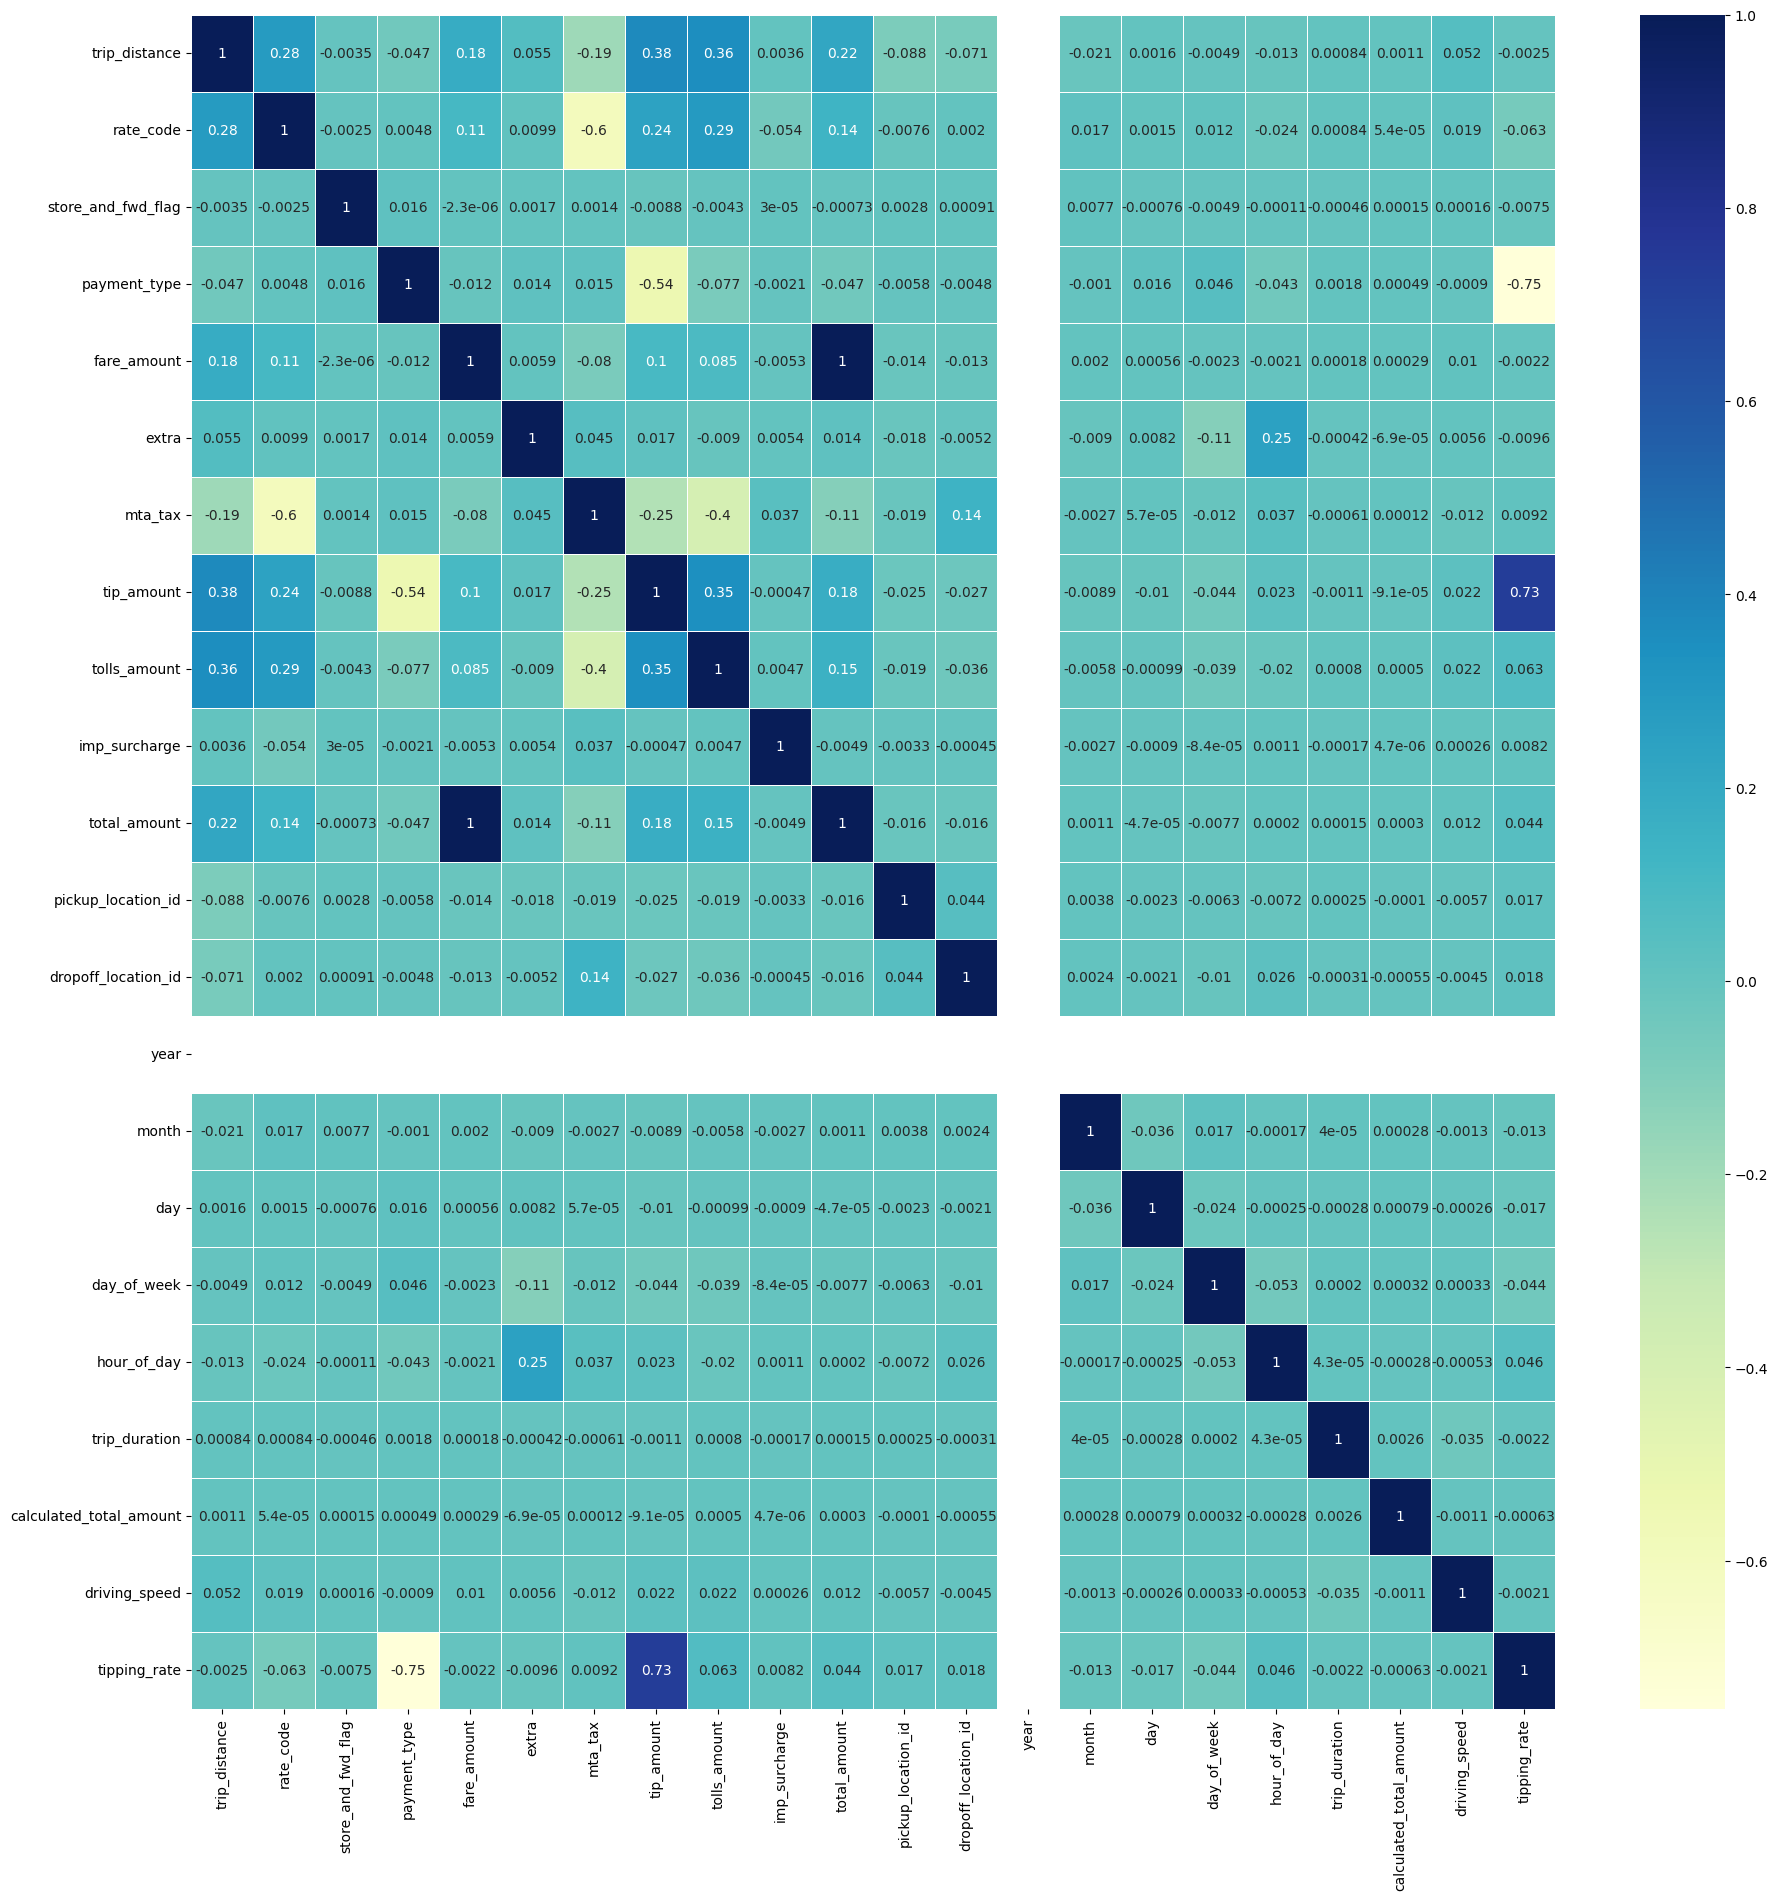

In [18]:
corr = data.corr()
# Drawing the heatmap
col = data.shape[1]
fig, ax = plt.subplots(figsize=(col,col))
ax = sns.heatmap(corr, cmap='YlGnBu', annot=True, linewidths=0.5);

In [19]:
# Enregistrer le dataset dans un autre fichier CSV
data.to_csv(transformed_data)
print('Done!')

Done!
